# Image captioning model with PyTorch (and Keras)
**Nishant Prabhu, 25 July 2020**

In this tutorial, we will learn to build a simple image captioning system - a model that can take in an image and generate sentence to describe it in the best possible way. This is a slightly advanced tutorial and requires that you understand some basics of natural language processing, the working and usage of pre-trained CNNs and recurrent network units like LSTMs. Don't worry if you don't; I'll provide brief explanations and links for further reading wherever I can. 

### System specifications

For this tutorial, most of magic is done with PyTorch. A few helper functions will be implemented with Keras. This should work on any version of these modules, although here are my specifications:

    1. Tensorflow (for Keras)        tensorflow-gpu==2.12.0
    2. PyTorch                       torch==1.5.1
    3. Python                        3.6.9
 
### Dataset downloads

For this tutorial, we are using the Flickr 8K dataset, which can be downloaded from Jason Brownlee's Github using the links on [this](https://github.com/goodwillyoga/Flickr8k_dataset) page.


### Special note
All file paths used below as specific to my system. Please change them accordingly if you are using the code as it is.

In [110]:
# Dependencies

import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu

import os
import string
import pickle
import numpy as np 
from PIL import Image 
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Image feature generation
The first thing we do is create rich features from images, which should be representative of its contents. It is best to use pre-trained deep CNNs for this task, since they are (usually) trained on very large datasets like ImageNet and can generate excellent features. I am going to use **VGG-16 by PyTorch**, which is VGGNet with 16 layers. The model's general architecture looks like the image below (which is not very clear, I think).

<img src="../images/vggnet.png" alt="VGG net architecture, from ResearchGate" width="500"/>

The final layer in this model is a fully connected layer mapping to 1000 units. This is kept for classification purposes (the ImageNet dataset has 1000 classes) and is not necessary for us. We'll retain only up to the penultimate layer of the model, which will give us a feature vector of 4096 dimensions for every image.

All images that go through the network must have the same shape. To do this, we define a transformation pipeline using `transforms.Compose` function from `torch`. This pipeline performs the following operations.
1. Resizes the image to (256, 256, 3).
2. Crops the image to only retain its center, which is of size (224, 224, 3). This assumes that the edges of the image do not contain any valuable information, which is reasonable most of the times.
3. Converts this PIL image into a torch tensor.
4. Normalizes each of the three channels of the image (RGB) with means (0.485, 0.456, 0.406) and standard deviations (0.229, 0.224, 0.225) respectively. These numbers were found to give optimal performance in ILSVRC (a very large computer vision competition), so we'll use it here as well. 

In [2]:
# Transforms, to get the image into the right format
img_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to generate image features
def generate_image_features(image_dir):
    
    vgg = models.vgg16(pretrained=True)
    layers = list(vgg.children())[:-1]
    model = torch.nn.Sequential(*layers)
    
    features= {}
    
    for f in os.listdir(image_dir):
        path = image_dir + '/' + f
        image = Image.open(path)
        image = img_transform(image)
        image = image.unsqueeze(0)
        x = model(image)
        features.update({f: x})
        
    return features

In [3]:
# Generate the image features

image_features = generate_image_features("../data/Flickr8k_Dataset/images")

I already generated the features beforehand and stored them as a pkl file. I will load them a few cells down the line, when we need it.

# Caption processing

Now that the image features are ready, let's shift our focus to the captions. Let's first have a look at the kind of data we have before we begin thinking about anything else. 

In [3]:
# Open captions file and read all lines
# Split over newline tags to get a list of lines
with open("../data/captions.txt", "r") as f:
    captions = f.read().split("\n")
    
# Display the first 10 captions
captions[:10]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .']

You can see that every image is associated with 5 captions (every image, because I checked). The first thing we might have to do is to organize this information in a more easier-to-work-with manner. A lookup table where the keys are the filename and a list of 5 captions associated with that file as its value should do. The Python equivalent of a lookup table is a dictionary, so we'll create a dictionary. To separate the keys from the sentences, we split each sentence on the tab delimiter "\t". Plus, we'll also remove the number tags (#0, #1, etc.) from the filenames.

In [4]:
# Create dictionary of captions 
captions_dict = {}

for line in captions:
    
    # Separate caption from filename
    contents = line.split("\t")
    
    # If there are no captions, then ignore
    if len(contents) < 2:
        continue
    
    filename, caption = contents[0], contents[1]
    
    # Exclude the number tag from filename
    filename = filename[:-2]
    
    # If the dictionary already has the filename in its keys ...
    # ... simply extend the list with current caption
    # Else, add the current caption in a list
    if filename in captions_dict.keys():
        captions_dict[filename].append(caption)
    else:
        captions_dict[filename] = [caption]

Let's split the image features and captions into training and test features.

In [25]:
# Create lists of filenames that go into training and testing data
# We will do a 70-30 split

split_point = int(0.7 * len(captions_dict))

training_files = list(captions_dict.keys())[:split_point]
test_files = list(captions_dict.keys())[split_point:]

# Segregate image features and captions for train and test into separate lists
train_features, train_captions = {}, {}
test_features, test_captions = {}, {}

for name in training_files:
    train_features[name] = image_features[name]
    train_captions[name] = captions_dict[name]
    
for name in testing_files:
    test_features[name] = image_features[name]
    test_captions[name] = captions_dict[name]

In [57]:
# I created these beforehand, so I'll just load them here

with open("../saved_data/train_features.pkl", "rb") as f:
    train_features = pickle.load(f)
    
with open("../saved_data/train_captions.pkl", "rb") as f:
    train_captions = pickle.load(f)
    
with open("../saved_data/test_features.pkl", "rb") as f:
    test_features = pickle.load(f)
    
with open("../saved_data/test_captions.pkl", "rb") as f:
    test_captions = pickle.load(f)

Now that we have it in the right form, we need to make some changes to the captions themselves. Machines do not understand textual information the way we do (similar to how we do not understand numbers like they do :P). We have to employ a method to convert each word into a number (or a set of numbers) which can indicate to the model the presence of certain words in a sentence.

### Tokenization
A simple solution to this would be to generate a vocabulary of all the words we have (bag of words) and assign an integer to each word. So you have a number identifying every single word that can occur in the examples that you have. This process is called **tokenization**. Integers, however, are not the best way to provide information to neural networks. As to what we can do about it, we will see a little later.

### Preprocessing
Some elements of caption sentences do not carry any meaning. Examples include uppercase alphabets, punctuation and numbers (at least for our purposes). First we will clean each sentence of these entities. Then, we will add two special tokens at the start and end of each sentence, to indicate the beggining and ending of the sentence (`startseq` and `endseq` respectively). These help the model know when to start and stop predicting. Once that is done, we tokenize all the lines using the `Tokenizer` class from `keras.preprocessing.text` submodule.

<img src="../images/text_processing.png" alt="Text processing" width="500">

### Padding
Neural networks expect inputs to be of fixed size when provided in a batch. Since captions might be of different lengths, we must pad each sentence at the end with special tokens (usually zeros) so that all inputs have the same shape. This process is known as **padding**. We will use the `pad_sequences` function from `keras.preprocessing.sequence` to perform this operation.

<img src="../images/padding_example.png" alt="Padding example" width="500">

In [26]:
def preprocess_line(line):
    line = line.split()                             # Convert to a list of words
    line = [w.lower() for w in line]                # Convert to lowercase
    line = [w for w in line if w.isalpha()]         # Remove numbers
    line = " ".join(line).translate(
        str.maketrans("", "", string.punctuation)   # Remove punctuation
    )
    line = "startseq " + line + " endseq"
    return line


def get_all_captions(captions_dict):
    """ Collects all captions in one list """
    
    captions = []
    for cpt_list in captions_dict.values():
        captions.extend(cpt_list)
    return captions


def tokenize_sentences(lines):
    tokenizer = Tokenizer(filters='')           # Initialize the tokenizer object
    tokenizer.fit_on_texts(lines)               # This generates the word index map
    vocab_size = len(tokenizer.word_index)+1    # The size of the vocabulary
    return tokenizer, vocab_size


def pad_tokens(tokens):
    return pad_sequences(tokens, padding='post') # Max length is auto-calculated

Let's call these functions on our corpus to get clean text. We will fit a tokenizer on the lines now but we will perform tokenizer later.

In [152]:
# Clean all the captions 

for filename, cpt_list in captions_dict.items():
    for i in range(len(cpt_list)):
        # Clean the caption
        cleaned_caption = preprocess_line(cpt_list[i])
        # Replace it in the correct location in the list
        cpt_list[i] = cleaned_caption
        
        
# Get all captions in a list and fit tokenizer

all_captions = get_all_captions(captions_dict)
tokenizer, vocab_size = tokenize_sentences(all_captions)

In [153]:
# How many words do we have?
print("Size of the vocabulary:", vocab_size)

Size of the vocabulary: 8372


# Model definition
Here comes the heart of this tutorial. But before that, for those who are new, below is a short primer on recurrent neural networks. Also, we'll discuss the correct representation of words in this section. If you know what I'm talking about, skip to **Model Structure** below.

## Recurrent neural networks
Simple fully connected networks assume that the examples provided to them are independent of each other. However, when we are dealing with sequences, this assumption falls apart. So it is not wise to use Dense layers to model such dependencies between consecutive sequence elements. This is where recurrent neural networks (RNNs) come to the rescue!

An RNN is capable of retaining some memory of the examples it has seen earlier by feeding back the activations of its hidden layer to itself (left image). We can **unroll the RNN in time** as shown in the image on the right. Each input layer + hidden layer + output in the right image is the **same network** at **different times**. Also note that the outputs taken from the RNN layer are usually its hidden layer activations i.e. $y_{0}=h_{0}$, $y_{1}=h_{1}$ and so on.

<img src="../images/rnn_example.png" alt="RNN diagram" width="800">

The network itself behaves as a fully connected network, with the output given by the expression below. You can see that it incorporates the effect of the current input as well as the previous hidden layer activations, as a weighted sum.

$$
y_{t} = W_{O} \cdot \left(W_{I}x_{t} + W_{H}h_{t-1} \right)
$$

## Gradient issues and LSTMs
RNNs suffer from two issues, namely **Vanishing** and **Exploding Gradients**. This greatly affects their performance, making them rather unpopular in the practical space. Schmidhuber et. al. came up with a novel solution to this with their **Long Short Term Memory (LSTM)** cells, as a replacement for the simple RNN cell. It's structure is shown below.

<img src="../images/lstm.png" alt="LSTM diagram" width="300">

We will not go into the details of what this is and how it works (you can read more about it in [Christopher Olah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)). All we need to know is that these cells have the capability to selectively read, forget and output information from inputs and past hidden states. They effectively solve the vanishing gradients problem; the exploding gradients - not so much. Anyway, they are better at modelling long term dependencies than RNNs.

## I/O specifications for recurrent layers
I think it's important that we know the way a layer of RNNs or LSTMs accepts and outputs tensors. The shape of input tensors to these layers are of the form **(batch size, sequence length, features)**. They output tensors in the very same format, only the number of features in the output will be equal to the number of hidden units of the recurrent layer.

<img src="../images/lstm_io.png" alt="LSTM I/O" width="800">

**Note for PyTorch**: PyTorch has the default convention (sequence length, batch size, features) for its recurrent layers. Passing the argument `batch_first = True` brings it to the format above.


## Embeddings and GloVe
Remember how we represented each word in our "vocabulary" as an integer? Integers are not the best way to capture information about words and their meanings. Think about it:
1. When you provide numbers to a network, it will treat its magnitude as a property of that word. Is there any basis for a word with index 1 to have smaller magnitude than a word with index 500?
2. Where there are numbers, you can compute distances. Would it make sense to have word 10 closer to 1 than word 20? 

Since the allotment of integers to words is arbitrary (first-come-first-serve actually), it doesn't make sense to use them as is. One way to tackle this issue would be to represent each word as a one hot vector (binary vector with 1 at the word's index and 0 everywhere else). This, unfortunately, again has problems.
1. Our vocabulary is 8372 words strong. Each word will be a 8372 dimensional, extremely sparse vector. If you use these tensors made of these with float data type, that would be an astronomical waste of memory (considering you even get to store that much). 
2. The distance issue is now different. Earlier, we had arbitrary distances between words. Now, each word is equidistant from every other word! That's equally unacceptable. Why? consider the words (NLP aficionado will cringe): king, queen, vase, Sunday. Don't you think "king" and "queen" should have less distance between them than with the other words? This is extremely important to understand relations between words from a corpus.

What else can we do? Well, how about we leave it to the network? We'll give it 8370 vectors which are randomly initialized (with smaller dimension, say a few hundred features) and let it learn the required spatial relations between words by modifying these vectors as it learns. Vectors generated through this process are called **Word Embeddings**. Enter **GloVe**!

<img src="../images/glove.png" alt="GloVe exampled, from Stanford NLP github" width="800">

GloVe stands for **Global Vectors**. Consider these vectors as a lookup table for our words. We go to this "learned" table, ask for the vector corresponsding to a word, and replace the word's integer token with this vector. GloVe is an excellent group of pre-trained vectors trained on very large corpora such as **Common Crawl** and **Wikipedia**, These vectors capture co-occurences of words really well, and we'll be using the same here. You can download pre-trained GloVe vectors [here](https://github.com/stanfordnlp/GloVe), generously made open-source by Stanford NLP group (for this tutorial, we are using the 6B vocab set (822 MB), trained on Wikipedia 2014). 

## Model structure
Finally! Here's what our model will look like (overall).

<img src="../images/model_architecture.png" alt="Model architecture" width="900">

The inputs to the model are the preprocessed image (224, 244, 3) and the integer tokens of the captions. The image's features are extracted (we have already done this) and reduced to 256 dimensions using a Linear layer with ReLU activation. 256 is an arbitrary choice, feel free to try other dimensions. We will use **Categorical Crossentropy** loss (Log softmax + Nonlinear logloss in PyTorch) for updating the parameters. Also, we'll use an Adam optimizer with constant learning rate. 

Providing the caption tokens, however, is not that straightforward. Imagine how YOU, as a human, would go about this.
1. Look at the image, extract some information and keep that in mind.
2. Generate the first word.
3. Look at the first word, remember what you saw in the image, and generate a second word so that the sentence so far is grammatically correct.
4. Look at the first and second words, and generate a third word. Refer to the image again if needed.
5. Continue this process until you think all of your words have been generated.

We will follow the same pattern for our network. So, our caption inputs will look like this.

<img src="../images/input_format.png" alt="Caption input format" width="300">

## Data Generator
I know this has gone too long, but here's one last thing before we start coding. Typically the datasets used for these will have very large sizes. Plus, for computing crossentropy, your predictions and targets will be one hot vectors of size 8372. If you try to pass the entire dataset in this form to your machine, it might run out of memory soon (and hang). To prevent this, we use a **data generator**.

A data generator is defined the same way a Python function is. The only difference is that it continuously **yields** (returns) batches of examples rather that returning a batch and falling silent. You can iterate over a generator object using the `next()` built-in function in Python. The generator starts running from the point it stopped last time whenever it is called - unlike a function which runs from the start each time.

We are first going to build the data generator for our model. Then, we will move on to building the model itself.

In [29]:
def data_generator(img_features, captions_dict, batch_size):
    
    # Initialize lists to store inputs and targets
    img_in, caption_in, caption_trg = [], [], []
    
    # Counter to check how many examples have been added
    count = 0
   
    # Run as and when called
    while True:
        for name, caption_list in captions_dict.items():
            
            # Get the relevant image features
            img_fs = img_features[name]
            
            for caption in caption_list:
                
                # Tokenize the sentence using the tokenizer
                # Remember to pass the string in a list 
                caption_seq = tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1, len(caption_seq)):
                    # Input is sequence until before i_th time step
                    # Target is the i_th time step
                    in_seq, trg_seq = caption_seq[:i], caption_seq[i]
                    
                    # Add these to the input/output lists
                    img_in.append(img_fs)
                    caption_in.append(in_seq)
                    caption_trg.append(trg_seq) # No need to one-hot encode this
                    count += 1
                
                    if count == batch_size:
                        # Pad the caption inputs since they all have different lengths
                        # Pre padding because if the sentence is too long, the LSTM ...
                        # ... might lose memory of important words that came long ago
                        caption_in = pad_sequences(caption_in, padding='pre')

                        # Yield these are torch tensors
                        yield (
                            torch.FloatTensor(img_in).squeeze(1),
                            torch.LongTensor(caption_in),
                            torch.LongTensor(caption_trg)
                        )

                        # I did .squeeze(1) for the image features because ...
                        # ... for me they have shape (batch size, 1, 4096) ...
                        # ... and I want to collapse the dimension at position 1
                        # So now it becomes (batch size, 4096)

                        # Reinitialize the lists
                        img_in, caption_in, caption_trg = [], [], []
                        
                        # Reset counter
                        count = 0

In [30]:
# Let's see if it's behaving how we want it to

gen = data_generator(train_features, train_captions, 32)

# Generate a batch by calling next() on the generator
img_in, caption_in, caption_trg = next(gen)

print("Image features:", img_in.shape)
print("Caption input:", caption_in.shape)
print("Caption target:", caption_trg.shape)

Image features: torch.Size([32, 4096])
Caption input: torch.Size([32, 15])
Caption target: torch.Size([32])


In [31]:
# Check contents of caption_in
caption_in

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    2],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    2,   42],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            2,   42,    7],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    2,
           42,    7,  253],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    2,   42,
            7,  253,   10],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    2,   42,    7,
          253,   10,  104],
        [   0,    0,    0,    0,    0,    0,    0,    0,    2,   42,    7,  253,
           10,  104,   35],
        [   0,    0,    0,    0,    0,    0,    0,    2,   42,    7,  253,   10,
          104,   35,  799],
        [   0,    0,    0,    0,    0,    0,    2,   42,    7,  253,   10,  104,
           35,  799,   10],
        [   0,    0

In [32]:
# Check the contents of caption_trg
caption_trg

tensor([  42,    7,  253,   10,  104,   35,  799,   10,  234,  750, 1952,    3,
          19,    4,   30, 1787,  817, 1006,    6,  585,   10,  750, 3199,    4,
           5,  102,    3,   40,   19,  227,  817,  680])

So it does provide us data in the staircase pre-padded format that we want. Great! Let's now start building our model. We will create a Network class that will inherit methods from `torch.nn.Module`. Loosely, this means all the updates, parameter initializations, backpropagation, etc. will be taken care of by `torch` itself. All we have to do is define what layers it will have, and how tensors will flow through them. 

In [33]:
# Model definition

class Network(torch.nn.Module):

    def __init__(self, glove_weights):

        # Inherit methods from torch.nn.Module
        super(Network, self).__init__()

        # Define layers
        self.fc_img = torch.nn.Linear(4096, 512)               # To reduce image features to 256
        self.embedding = torch.nn.Embedding(vocab_size, 200)   # We will initialize this with GloVe
        self.lstm = torch.nn.LSTM(200, 512, batch_first=True)  # Generates hidden representations
        self.fc_wrapper = torch.nn.Linear(1024, 1024)          # For some more flexibility
        self.fc_output = torch.nn.Linear(1024, vocab_size)     # Gives the output probabilities

        # Initialize the embedding layer's weights with GloVe
        # Although they are pre-trained, we'll let them train again ...
        # ... so they can become more configured to our data
        self.embedding.weight = torch.nn.Parameter(glove_weights)


    def forward(self, img_in, caption_in):

        # Reduce the image features to 256 dimensions
        x1 = self.fc_img(img_in)              # Shape (batch_size, 256)
        x1 = F.relu(x1)

        # Generate embeddings for caption tokens
        x2 = self.embedding(caption_in)

        # Pass them through the LSTM layer and ...
        # ... preserve only the last output
        x2, _ = self.lstm(x2)             # Ignore the LSTM's hidden state
        x2 = x2[:, -1, :].squeeze(1)      # Shape: (batch_size, 256)

        # Concatenate x1 and x2 along the ...
        # ... features dimension (-1)
        x3 = torch.cat((x1, x2), dim=-1)  # Shape: (batch_size, 512)

        # Pass this through the output layer to get predictions
        x3 = self.fc_wrapper(x3)
        x3 = F.relu(x3)

        x3 = self.fc_output(x3)           # Shape: (batch_size, vocab_size)

        # Log softmax the outputs
        out = F.log_softmax(x3, dim=-1)

        return out

### Processing GloVe embeddings
Before we test our model out, let's process the GloVe embeddings so we can initialize the embedding layer with its weights. We have a text file with several lines containing the word and its embeddings separated by newline tags "\n". We'll read them in an store them in a list to start with. 

**Note:** This file is 690 MB+. Ensure you have enough RAM available when you're loading it.

In [35]:
# Read GloVe files

with open("../glove/glove.6B.200d.txt", "r") as f:
    glove = f.read().split("\n")

In [36]:
# The first line
glove[0]

'the -0.071549 0.093459 0.023738 -0.090339 0.056123 0.32547 -0.39796 -0.092139 0.061181 -0.1895 0.13061 0.14349 0.011479 0.38158 0.5403 -0.14088 0.24315 0.23036 -0.55339 0.048154 0.45662 3.2338 0.020199 0.049019 -0.014132 0.076017 -0.11527 0.2006 -0.077657 0.24328 0.16368 -0.34118 -0.06607 0.10152 0.038232 -0.17668 -0.88153 -0.33895 -0.035481 -0.55095 -0.016899 -0.43982 0.039004 0.40447 -0.2588 0.64594 0.26641 0.28009 -0.024625 0.63302 -0.317 0.10271 0.30886 0.097792 -0.38227 0.086552 0.047075 0.23511 -0.32127 -0.28538 0.1667 -0.0049707 -0.62714 -0.24904 0.29713 0.14379 -0.12325 -0.058178 -0.001029 -0.082126 0.36935 -0.00058442 0.34286 0.28426 -0.068599 0.65747 -0.029087 0.16184 0.073672 -0.30343 0.095733 -0.5286 -0.22898 0.064079 0.015218 0.34921 -0.4396 -0.43983 0.77515 -0.87767 -0.087504 0.39598 0.62362 -0.26211 -0.30539 -0.022964 0.30567 0.06766 0.15383 -0.11211 -0.09154 0.082562 0.16897 -0.032952 -0.28775 -0.2232 -0.090426 1.2407 -0.18244 -0.0075219 -0.041388 -0.011083 0.078186 0.

Each line is a string with the first element as the word and the remaining as its 200 dimensional embedding values. We will split this string on space, separate the word from the embeddings and convert the embeddings to float values. Let's store this in a dictionary so it feels more like a lookup table. There are issues with some of the strings in it, so we add these in a `try except` block. Anytime an error occurs, the loop will move to the next iteration.

In [37]:
# Initialize the dictionary
glove_dict = {}

for line in glove:
    try:
        elements = line.split()
        word, vector = elements[0], np.array([float(i) for i in elements[1:]])
        glove_dict[word] = vector
    except:
        continue

Our vocabulary definitely does not have all the words that are there in this dictionary. Also, there might be some vague words in our vocabulary that aren't in this dictionary. Our goal now is to construct a tensor of the size of our vocabulary (8372) where a word's vector will be replaced with the corresponding GloVe vector if it is present there; else, it will be kept random.

In [38]:
# Generate the embedding matrix of shape (vocab_size, 200)
# Our vocabulary is accessible as a dictionary using tokenizer.word_index

# Initialize random weight tensor
glove_weights = np.random.uniform(0, 1, (vocab_size, 200))
found = 0

for word in tokenizer.word_index.keys():
    if word in glove_dict.keys():
        # If word is present, replace the vector at its location ...
        # ... with corresponding GloVe vector
        glove_weights[tokenizer.word_index[word]] = glove_dict[word]
        found += 1
    else:
        # Otherwise, let it stay random
        continue
        
print("Number of words found in GloVe: {} / {}".format(found, vocab_size))

Number of words found in GloVe: 7715 / 8372


Great! 7715 words from our vocabulary of 8372 words were found in GloVe. Now let's initialize a sample model and check if its outputs are as we expect them to be.

In [151]:
# Initialize the model
model = Network(glove_weights=torch.FloatTensor(glove_weights))

# Pass the batch we generate earlier
preds = model(img_in, caption_in)

# Print shape of output
print("Output shape:", preds.shape)

Output shape: torch.Size([32, 8372])


This seems to be working fine as well. Now we'll write a few helper functions that we'll need to train the model. 

In [17]:
def compute_loss(predictions, target):
    """ 
        Computes the nonlinear logloss for 
        predictions, given target 
    """
    # Expected shapes of inputs:
    # Prediction: (batch_size, vocab_size)
    # Targets: (batch_size)
    
    return F.nll_loss(predictions, target)
    
    
def learning_step(img_in, caption_in, caption_trg):
    """ 
        Given a batch of inputs and outputs, this function
        trains the model on it and updates its parameters
    """
    # Zero out optimizer gradients
    optimizer.zero_grad()
    
    # Generate predictions
    preds = model(img_in, caption_in)
    
    # Compute loss
    loss = compute_loss(preds, caption_trg)
    
    # Compute gradients by backpropagating loss 
    loss.backward()
    
    # Update model parameters through the optimizer
    optimizer.step()
    
    return loss

# Training the model
Alright, let's train the model now. Here's our training strategy:
1. For every epoch, initialize the data generator and loss counter.
2. Perform len(captions_map) number of iterations on the generator. This will ensure that we go over each image and all of its captions in the training dataset.
3. Perform a learning step for the batch generated during an iteration and update relevant objects.
4. Perform some console outputs so you can track its progress.
5. Save the model.

It is recommended that you reproduce this code in a Python script and run the script as a whole, instead of training the model here. This is important for people using GPUs and CUDA for training the model. 

In [21]:
epochs = 20
steps_per_epoch = len(train_captions)

# Initialize the model and optimizer
model = Network(glove_weights=torch.FloatTensor(glove_weights))
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop

for epoch in range(epochs):
    print("Epoch {}".format(epoch+1))
    print("--------------------------------")
    
    # Initialize the data generator and loss counter
    d_gen = data_generator(train_features, train_captions)
    total_loss = 0
    
    # Perform iterations over the generator
    for batch in range(steps_per_epoch):
        
        # Create a batch
        img_in, caption_in, caption_trg = next(d_gen)
        
        # Performing a learning step and record loss
        loss = learning_step(img_in, caption_in, caption_trg)
        
        # Add to total loss
        total_loss += loss
        
        # Provide a status update every 1000 steps (total 5663)
        if batch % 1000 == 0:
            print("Epoch {} - Batch {} - Loss {:.4f}".format(
                epoch+1, batch, loss
            ))
            
    # Average the loss for this epoch and print it
    epoch_loss = total_loss/steps_per_epoch
    
    print("\nEpoch {} - Average loss {:.4f}".format(
        epoch+1, epoch_loss
    ))
    
    # Save the model
    torch.save(model.state_dict(), "../saved_data/models/model_{}".format(epoch+1))
    
    print("\n======================================\n")

# Evaluation
Now that we have a trained model, we'll see how well it does. We will write a translation function, and another function to quantify its performance using a performance metric called BLEU score.

### Translation
We follow the same strategy for translation as we did while training. The `translate` function only needs the image, which we provide as its VGG-16 features. The `startseq` token starts off the prediction. Each time, we predict a word, add it to our sentence, tokenize the new sentence (and pad it) and continue the procedure. The loop is broken either when `endseq` is encountered or maximum length is reached.

### BLEU scores
To compare model performance for seq2seq tasks (ones where it generates a sequence and we have to match it with reference sequences to see how well it has done), we use **BLEU scores**. We will not discuss its computation in details (you can read more about it [here](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/#:~:text=Crash%2DCourse%20Now-,Bilingual%20Evaluation%20Understudy%20Score,sentence%20to%20a%20reference%20sentence.&text=The%20score%20was%20developed%20for,by%20automatic%20machine%20translation%20systems.)), but below is what we need to know. 

This function checks the correctness of the generated sentence at multiple levels, as specified by the user. That is, it checks uni-gram matches (single words, BLEU-1), bi-gram matches (two word pairs, BLEU-2), tri-grams, and so on. For our purposes, we will check the values of BLEU-1 to BLEU-4. A decent model should have its BLEU scores in the following ranges (taken from Where to put the Image in an Image Caption Generator, a 2017 paper).

1. BLEU-1: 0.401 to 0.578
2. BLEU-2: 0.176 to 0.390
3. BLEU-3: 0.099 to 0.260
4. BLEU-4: 0.059 to 0.170

To compute BLEU scores, we will use the `corpus_bleu` function from `nltk.translate.bleu_score`. It needs 3 parameters:
1. List of **references**: List of documents (lists as well), each document being the set of possible correct translations.
2. List of **hypotheses**: List of predictions.
3. Weights: These determine the value of K in BLEU-K scores.

In [119]:
# Translate function

def translate(features):
    
    # Convert features to a Float Tensor
    features = torch.FloatTensor(features)
    
    # String to which words keep getting added 
    result = "startseq "
    
    for t in range(1, max_length-1):
        
        # Tokenize the current sentence
        in_seq = tokenizer.texts_to_sequences([result])
        
        # Pad it to max_length and convert to torch LongTensor
        in_seq = pad_sequences(in_seq, maxlen=max_length, padding='pre')
        in_seq = torch.LongTensor(in_seq)
        
        # Generate predictions and pick out the predicted word ...
        # ... from tokenizer's index_word map
        preds = model(features, in_seq)
        pred_idx = preds.argmax(dim=-1).detach().numpy()[0]
        word = tokenizer.index_word.get(pred_idx)
        
        # If no word is returned or endseq is returned, stop the process
        if word is None or word == 'endseq':
            break
            
        # Otherwise add the predicted word to the sentence
        result += word + " "
        
    # Return the sentence minus the startseq
    return " ".join(result.split()[1:])


# Function compute BLEU scores

def evaluate_model(feature_dict, caption_dict):
    
    # Initialize lists to store references and hypotheses
    references = []
    hypotheses = []
    
    for name in tqdm(feature_dict.keys()):
            
        # Generate prediction and append that to hypotheses
        prediction = translate(feature_dict[name])
        hypotheses.append(prediction.split())

        # Get all reference captions in a list and append ...
        # ... it to references
        refs = [caption.split() for caption in caption_dict[name]]
        references.append(refs)
            
    # Compute BLEU scores
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    
    print("BLEU-1: {:.4f}".format(bleu_1))
    print("BLEU-2: {:.4f}".format(bleu_2))
    print("BLEU-3: {:.4f}".format(bleu_3))
    print("BLEU-4: {:.4f}".format(bleu_4))

### Loading saved model
Let's now load the saved model and see how well it performs.

In [39]:
# We'll accept captions that are at most 20 words long
max_length = 20

# Initialize a new model
model = Network(glover_weights=torch.FloatTensor(glove_weights))

# Copy trained model's weights and other parameters to it.
# map_location for CUDA users only, it loads everything to your CPU
model.load_state_dict(torch.load("../saved_data/models/model_36", map_location=torch.device('cpu')))

<All keys matched successfully>

In [121]:
# Train data evaluation
evaluate_model(train_features, train_captions)

# Test data evaluation
evaluate_model(test_features, test_captions)


BLEU-1: 0.4176
BLEU-2: 0.2775
BLEU-3: 0.2132
BLEU-4: 0.1733



BLEU-1: 0.3485
BLEU-2: 0.1750
BLEU-3: 0.0933
BLEU-4: 0.0448


The model performs surprisingly well on the training dataset, and decent on the test dataset. There could be multiple reasons to this.
1. Overfitting. There might have been too many parameters to train for the amount of data we have. Given the gap in training and test metric values (and the brilliant performance on training data), this is the most likely case.
2. There were elements in the images of test dataset that weren't encountered by the model very often in the train dataset. It didn't learn how to use the words describing them very well, and it couldn't reproduce them during testing.
3. The model needs to train more. This would depend on heuristics, however.

## Examples
Let's now look at some examples and see how good or bad it really is. First, let's see some **good predictions** from the test dataset.

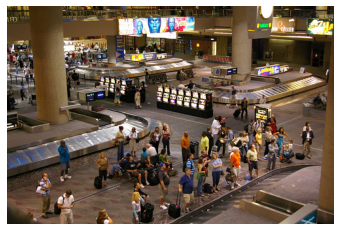

[CAPTION]: group of people ice street with building surrounding them


In [128]:
name = list(test_features.keys())[6]
image = PIL.Image.open("../data/Flickr8k_Dataset/images/" + name)

plt.imshow(image)
plt.axis('off')
plt.show()

print("[CAPTION]: {}".format(translate(test_features[name])))

# It says ice street (which makes no sense) but the rest is fine.

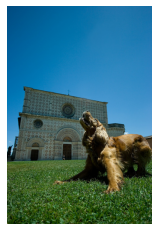

[CAPTION]: the brown dog is running through the grass with ball in its mouth


In [137]:
name = list(test_features.keys())[15]
image = PIL.Image.open("../data/Flickr8k_Dataset/images/" + name)

plt.imshow(image)
plt.axis('off')
plt.show()

print("[CAPTION]: {}".format(translate(test_features[name])))

# There's no ball in it's mouth but otherwise it's quite accurate.

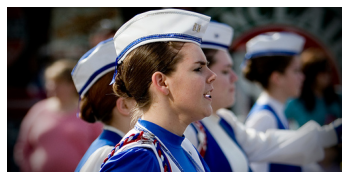

[CAPTION]: the person in the marching band


In [141]:
name = list(test_features.keys())[19]
image = PIL.Image.open("../data/Flickr8k_Dataset/images/" + name)

plt.imshow(image)
plt.axis('off')
plt.show()

print("[CAPTION]: {}".format(translate(test_features[name])))

# Seems fine.

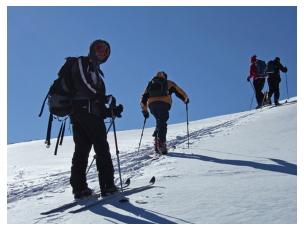

[CAPTION]: group of people playing soccer in the snow


In [147]:
name = list(test_features.keys())[21]
image = PIL.Image.open("../data/Flickr8k_Dataset/images/" + name)

plt.imshow(image)
plt.axis('off')
plt.show()

print("[CAPTION]: {}".format(translate(test_features[name])))

# They aren't playing soccer, but there's people and snow.

## Bad predictions
It is only fair to show the reader some bad predictions. Some comments on why they might have been that way are also given.

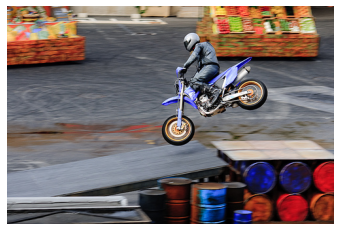

[CAPTION]: man jumps on bike outside with another man on it and black and red helmet


In [142]:
name = list(test_features.keys())[0]
image = PIL.Image.open("../data/Flickr8k_Dataset/images/" + name)

plt.imshow(image)
plt.axis('off')
plt.show()

print("[CAPTION]: {}".format(translate(test_features[name])))

# While it has detected a man and a bike, it probably thought that 
# the man is jumping onto it because he's in air

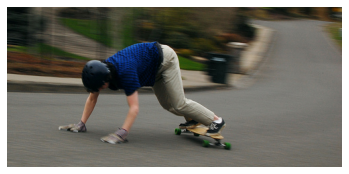

[CAPTION]: two men are playing in front of small grass


In [148]:
name = list(test_features.keys())[22]
image = PIL.Image.open("../data/Flickr8k_Dataset/images/" + name)

plt.imshow(image)
plt.axis('off')
plt.show()

print("[CAPTION]: {}".format(translate(test_features[name])))

# The green patches might have been detected as grass, and the 
# trash can behind might have been detected as the second person

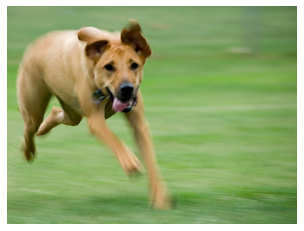

[CAPTION]: two dogs run through the grass


In [150]:
name = list(test_features.keys())[24]
image = PIL.Image.open("../data/Flickr8k_Dataset/images/" + name)

plt.imshow(image)
plt.axis('off')
plt.show()

print("[CAPTION]: {}".format(translate(test_features[name])))

# This might seem near accurate, but shuffling through the images
# reveals that the model often associates the word "two" wherever "dog"
# appears. Perhaps there's too many images of two dogs doing something.

# Endnote
Here you are! A decent image caption generator in no time (excluding the training time). The model that I proposed here is very simplistic. There's definitely much better models out there which can do the job much better than this one. However, this was meant to be a primer and fun project for people venturing into natural language processing and computer vision. 

Experiment a little more and you might find something better than what I have here. Here's some food for thought.
1. While generating captions, what does the model actually use? Does it use the image features that we attached, or the words generated so far? A combination of both? If yes, what kind of combination? You might want to have a look at **attention mechanism** for natural language processing.
2. What do the features extracted by VGGNet represent? If there are three images, two with dogs and one with kids, will the vectors for dog images be closer in distance than the vector for kids' image?

What deep learning is truly capable of is bound (or not) by your creativity and imagination.